<a href="https://colab.research.google.com/github/EllouziMedAmin/DSWithPytorch/blob/main/get_movie_title__by_description.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chromadb

In [2]:
import re
import pandas as pd
import seaborn as sns
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [3]:
def max_word_count(txt_list:list):
    max_length = 0
    for txt in txt_list:
        word_count = len(re.findall(r'\w+', txt))
        if word_count > max_length:
            max_length = word_count
    return f"Max Word Count: {max_length} words"

In [4]:
# chroma default sentence model "all-MiniLM-L6-v2"
# https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2
# max input length: 256 characters
model_max_chunk_length = 256
token_splitter = SentenceTransformersTokenTextSplitter(
    tokens_per_chunk=model_max_chunk_length,
    model_name="all-MiniLM-L6-v2",
    chunk_overlap=0
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
text_path = "movies.csv"
df_movies_raw = pd.read_csv(text_path, parse_dates=['release_date'])

In [12]:
df_movies_raw.head(2)

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
1,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...


In [13]:
#filter movies for missing title or overwiew
selected_cols = ['id', 'title', 'overview', 'vote_average', 'release_date']
df_movies_filt = df_movies_raw[selected_cols].dropna()

In [14]:
# filter for unique ids
df_movies_filt = df_movies_filt.drop_duplicates(subset=['id'])

In [15]:
df_movies_filt.shape

(36899, 5)

In [16]:
max_word_count(df_movies_filt['overview'])

'Max Word Count: 193 words'

In [17]:
descriptions_len = []
for txt in df_movies_filt.loc[:, "overview"]:
    descriptions_len.append(len(re.findall(r'\w+', txt)))

<Axes: ylabel='Count'>

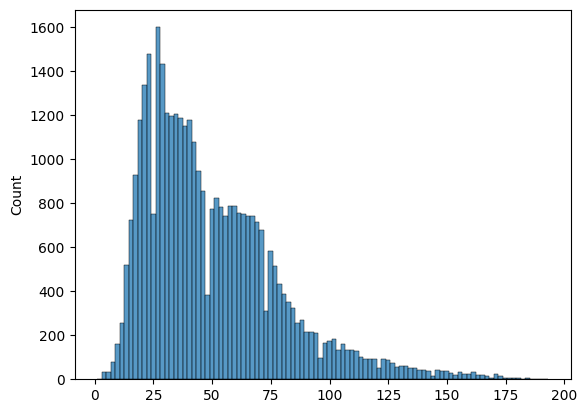

In [18]:
#Word Distribution
sns.histplot(descriptions_len, bins=100)

In [19]:
embedding_fn = SentenceTransformerEmbeddingFunction()

In [20]:
chroma_db = chromadb.PersistentClient(path="db")

In [21]:
chroma_db.list_collections()

[]

In [22]:
chroma_collection = chroma_db.create_collection("movies", embedding_function=embedding_fn)

In [23]:
#add all tokens to collection
ids = [str(i) for i in df_movies_filt['id'].tolist()]
documents = df_movies_filt['overview'].tolist()
titles = df_movies_filt['title'].tolist()
metadatas = [{'source': title} for title in titles]

In [24]:
chroma_collection.add(documents=documents, ids=ids, metadatas=metadatas)

In [25]:
len(chroma_collection.get()['ids'])

36899

In [26]:
def get_title_by_description(query_text:str):
    n_results = 3
    res = chroma_collection.query(query_texts=[query_text], n_results=n_results)
    for i in range(n_results):
        print(f"Title: {res['metadatas'][0][i]['source']} \n")
        print(f"Description: {res['documents'][0][i]} \n")
        print("-------------------------------------------------")

In [27]:
get_title_by_description(query_text="superhero, spider")

Title: Spider-Man 

Description: After being bitten by a genetically altered spider at Oscorp nerdy but endearing high school student Peter Parker is endowed with amazing powers to become the superhero known as Spider-Man. 

-------------------------------------------------
Title: Spider-Man: The Mythology of the 21st Century 

Description: The mythology behind Spider-Man 

-------------------------------------------------
Title: Spiderbabe 

Description: A socially awkward young woman gets bitten by a radioactive spider and becomes a crime-fighting superhero and tries to defeat a nefarious super villain while going after any man (or woman) she wants to bed down with. 

-------------------------------------------------


In [32]:
get_title_by_description(query_text="superhero bat")

Title: LEGO DC Comics Super Heroes: Justice League - Gotham City Breakout 

Description: The caped crusader reluctantly agrees to let Batgirl and Nightwing take him on a long overdue vacation from crime-fighting while Superman and the Justice League watch over Gotham City. 

-------------------------------------------------
Title: Superman/Shazam!: The Return of Black Adam 

Description: Chosen the world’s protector against the Seven Deadly Enemies of Man – pride envy greed hatred selfishness laziness and injustice – young Billy Batson accepts his destiny as Captain Marvel. Battling alongside Superman against nefarious Black Adam Billy soon discovers the challenge super heroes ultimately face: is it revenge or justice? 

-------------------------------------------------
Title: Shazam! Fury of the Gods 

Description: Billy Batson and his foster siblings who transform into superheroes by saying "Shazam!" are forced to get back into action and fight the Daughters of Atlas who they must st